<a href="https://www.kaggle.com/code/bensonduong/font-type-image-classification?scriptVersionId=95708082" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Typeface Categorization using Unsupervised Learning, Convolutional Neural Network, and OpenCV**
* This data science computer vision project will be about categorizing font categories from photoscanned images of paper text.
* The font categorization will be in terms of general "font types", *not* specific typefaces (like Arial, Times New Roman, etc.), meaning moreso categories like "serifed", "san-serifed", etc.
* These font categories will be initially grouped through **Unsupervised Learning**, specifically **Spectral Embedding** and **K-means Clustering**, which in turn uses actual typefaces from the UC Irvine Font Dataset https://archive.ics.uci.edu/ml/datasets/Character+Font+Images
* These labellings will be used for training a **convolutional neural network** with variable-input-size, meaning it can classify the general font types of completely new and unseen typefaces. This CNN will allow variable input size for the versatile dimensions of the incoming segmented characters.
* Using OpenCV, photo-scanned images of text can be inputted, undergo character image segmenet, and have its font types classified.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = (7,7)

In [2]:
import sklearn.neighbors
import sklearn.manifold
from sklearn.cluster import KMeans

from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import cv2
import urllib.request
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras.optimizers import adam_v2

In [4]:
file_names = []
file_paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath = (os.path.join(dirname, filename))
        file_paths.append(filepath)
        file_names.append(filename)

In [5]:
#PATH_FOLDER = "/content/drive/MyDrive/dsprojects/dsproject_imagery/dsprojects_fonts/"
#font_folder_path = PATH_FOLDER + "/fonts/"
#uci_font_family_csv_file_names = os.listdir(font_folder_path) # list of file_names. Each file is the csv for a specific font

In [6]:
# For each font's csv table, the column "m_label" denotes an identifier for a certain character
# The variables below are the m_labels for specific character groups (alphanumeric - uppercase, lowercase, digits)
MIN_M_LABEL = 33
MAX_M_LABEL = 126
m_labels_all = list(range(MIN_M_LABEL,MAX_M_LABEL+1))
m_labels_alphanum_alpha_upper = list(range(m_labels_all[32], m_labels_all[32+26]))
m_labels_alphanum_alpha_lower = list(range(m_labels_all[64], m_labels_all[64+26]))
m_labels_alphanum_num = list(range(m_labels_all[16], m_labels_all[16+10]))

# each row of the csv table has a 20x20 image for the character it represents, which can be made using a group of 400 columns. These column names are collected here for future use
pixel_column_names = []
for i in range(0, 20):
    for j in range(0, 20):
        pixel_column_name = "r{0}c{1}".format(str(i),str(j))
        pixel_column_names.append(pixel_column_name)


# You can change which characters you want to use below in the CHOSEN_M_LABELS variable . 
# But for this unsupervised classification, I'm going to just use the 26 capital letters to represent each font
# My main reason is that capital letters are arguably square-shaped and thus proportionally consistent in anatomy for most fonts.
# Because in this dataset, thin or wide characters get forcibly stretched or narrowed to fit a 20x20 space. 
CHOSEN_M_LABELS = []
CHOSEN_M_LABELS += m_labels_alphanum_alpha_upper
#CHOSEN_M_LABELS += m_labels_alphanum_alpha_lower
#CHOSEN_M_LABELS += m_labels_alphanum_num


CHARACTERS_AMOUNT = len(CHOSEN_M_LABELS)
# I'm going to iterate through each font file to read the csv, and keep just the characters from the chosen m_labels
# without any bolded or italicized or duplicated rows
unraveled_unsupervised = []
font_visualizations = []
passed_font_families = []
failed_font_families = []

uci_font_family_csv_file_names = file_names
range_len_uci_font_family_csv_file_names = range(len(uci_font_family_csv_file_names))
range_len_uci_font_family_csv_file_names = tqdm(range_len_uci_font_family_csv_file_names)

for i in range_len_uci_font_family_csv_file_names:
    #if (((i+1)%25)==0): print(i+1, len(uci_font_family_csv_file_names));
    uci_font_family_csv_file_name = uci_font_family_csv_file_names[i]
    uci_font_family = uci_font_family_csv_file_name.split(".csv")[0]
    # uci_font_family_csv_file_path = font_folder_path + uci_font_family_csv_file_name
    uci_font_family_csv_file_path = file_paths[i]
    temp_uci_font_family_df_orig = pd.read_csv(uci_font_family_csv_file_path)

    
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["m_label"].isin(CHOSEN_M_LABELS)] 
    # get the chosen labels 
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.sort_values("m_label") 
    # make sure that the characters are in order, which is necessary for a horizontal concatenation and consistent embedding later on.
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["strength"] <= 0.5] 
    # remove bolded
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["italic"] <= 0.5] 
    # remove italicized
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.drop_duplicates(subset=["m_label","strength","italic"]) 
    # remove any duplicates left over

    # CHARACTERS_AMOUNT is 26 if you are just doing uppercase letters

    try:
        assert temp_uci_font_family_df_orig.shape[0] == CHARACTERS_AMOUNT
        
        temp_uci_font_family_df_pixels = temp_uci_font_family_df_orig[pixel_column_names]
        # temp_uci_font_family_df_pixels.shape == (26, 400)
        # each row is a character, and is a vector in R^400, that can be reshaped as a 20x20 image.

        temp_uci_font_family_char_concat = temp_uci_font_family_df_pixels.values.reshape((20*20*CHARACTERS_AMOUNT,))
        # we reshape the font's whole 26x400 table to be a horizontal concatenation as a vector in R^ 20*20*26
        # in other words, each row is joined end-to-end 
        unraveled_unsupervised.append(temp_uci_font_family_char_concat)

        font_visualizations.append(temp_uci_font_family_char_concat.reshape(CHARACTERS_AMOUNT,20,20))
        # this gives back a list of 20x20 arrays that can be used for EDA visualization

        passed_font_families.append(uci_font_family)
    except Exception as e:
        #print(e)
        failed_font_families.append(uci_font_family)
        pass

100%|██████████| 153/153 [00:49<00:00,  3.07it/s]


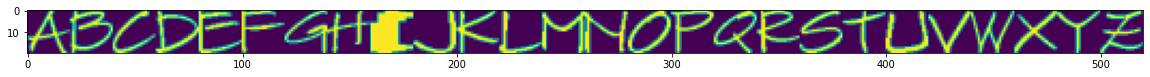

In [7]:
# demonstration of using the font_visualization list
GIVEN_FONT = "SKETCHFLOW" # input any font from the dataset, make sure it's in capital letters

fig_temp, ax_temp = plt.subplots(figsize=(20,20))
given_font_index = passed_font_families.index(GIVEN_FONT)
plt.imshow(np.hstack(font_visualizations[given_font_index]))

## **Unsupervised Grouping of Fonts**

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


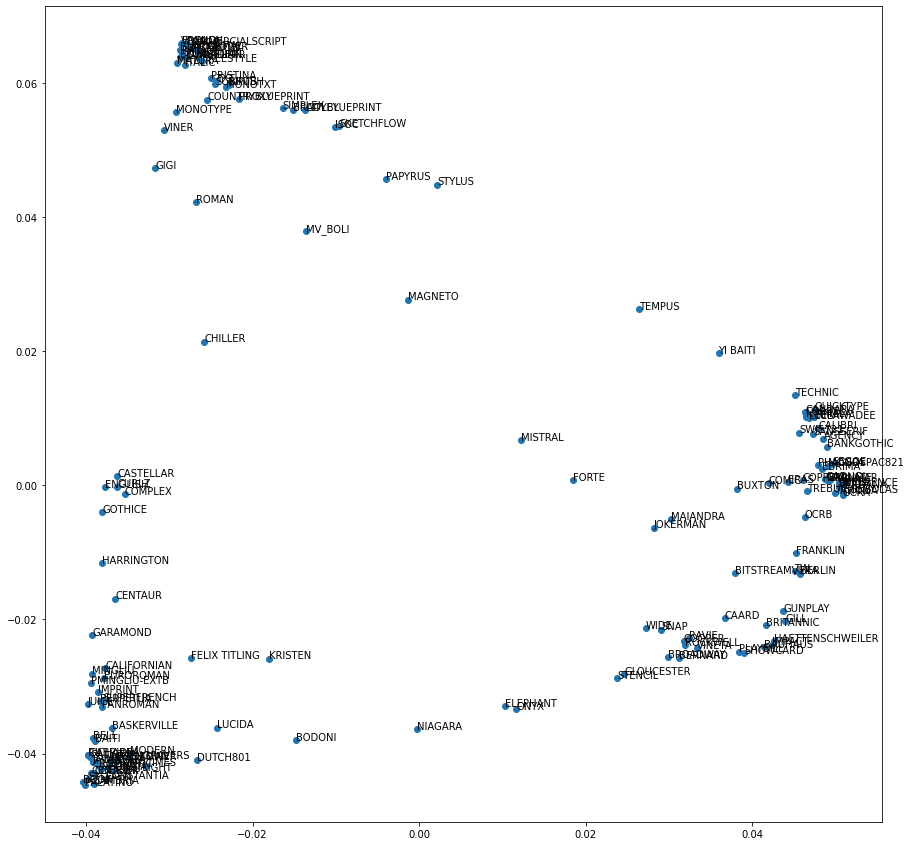

In [8]:
eig_fonts_x = np.array(unraveled_unsupervised)
# eig_fonts_x.shape # is (147, 10400)
eig_fonts_x_normalized = normalize(eig_fonts_x, axis=1) #
#eig_fonts_cov = np.cov(eig_fonts_x_normalized) # 
eig_fonts_similarity_matrix = eig_fonts_x_normalized @ eig_fonts_x_normalized.T
W = eig_fonts_similarity_matrix

np.random.seed(1)
N_NEIGHBORS = 5
W = sklearn.neighbors.kneighbors_graph(eig_fonts_x, n_neighbors=N_NEIGHBORS)

N_EMBEDDINGS = 2
embedding = sklearn.manifold.spectral_embedding(W, n_components=N_EMBEDDINGS)

eigfont_embeddings_df = pd.DataFrame()
eigfont_embeddings_df["font"] = passed_font_families
embedding_column_names = []
for i in range(N_EMBEDDINGS):
    embedding_column_name = "embedding_{0}".format(i)
    embedding_column_names.append(embedding_column_name)
    eigfont_embeddings_df[embedding_column_name] = embedding[:,i]


# embedding.shape
x = embedding[:,0]
y = embedding[:,1]
n = passed_font_families
            
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

* After the use of spectral embedding, we can clearly see some well defined clusters. 
  * Serifed Fonts like Garamond and Bookman are clumped on the bottom left.
  * San-Serifed Fonts are clumped on the right
  * Calligraphic Fonts are clumped on the top

* Next step is to use K-means Clustering on this embedding. Sensibly, k should be = 3

In [9]:
N_CLUSTERS = 3
np.random.seed(1)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(eigfont_embeddings_df[embedding_column_names])
kmeans.labels_

eigfont_embeddings_df["cluster"] = kmeans.labels_

# Another thing we can do is to be less discrete with grouping the fonts. 
# Instead being binary, this part will ambiguously decide how each font can be grouped under each cluster group as a proportion, based on the distance to the cluster centroid

cluster_center_i_distance_column_names = []
for i in range(N_CLUSTERS):
    cluster_center_i = kmeans.cluster_centers_[i]

    cluster_center_i_distance = 0
    for j in range(N_EMBEDDINGS):
        cluster_center_i_distance += (eigfont_embeddings_df["embedding_{0}".format(j)] - cluster_center_i[j])**2
    cluster_center_i_distance_column_name = "cluster_center_{0}_distance".format(i)
    cluster_center_i_distance_column_names.append(cluster_center_i_distance_column_name)
    eigfont_embeddings_df[cluster_center_i_distance_column_name] = cluster_center_i_distance

eigfont_embeddings_df_cluster_center_i_distance = eigfont_embeddings_df[cluster_center_i_distance_column_names]
#((eigfont_embeddings_df_cluster_center_i_distance)*-1).add(eigfont_embeddings_df_cluster_center_i_distance.max(axis=1),axis="index")

#(0.5*(1-(normalize(eigfont_embeddings_df_cluster_center_i_distance, axis=1,norm="l1"))))#.sum(axis=1)
eigfont_embeddings_df_cluster_center_i_distance = 1/eigfont_embeddings_df_cluster_center_i_distance
eigfont_embeddings_df_cluster_center_i_proximity = normalize(eigfont_embeddings_df_cluster_center_i_distance,axis=1,norm="l1")
eigfont_embeddings_df[cluster_center_i_distance_column_names] = eigfont_embeddings_df_cluster_center_i_proximity
eigfont_embeddings_df = eigfont_embeddings_df.rename(columns=dict([("cluster_center_{0}_distance", "cluster_center_{0}_proximity") for i in range(N_CLUSTERS)]))

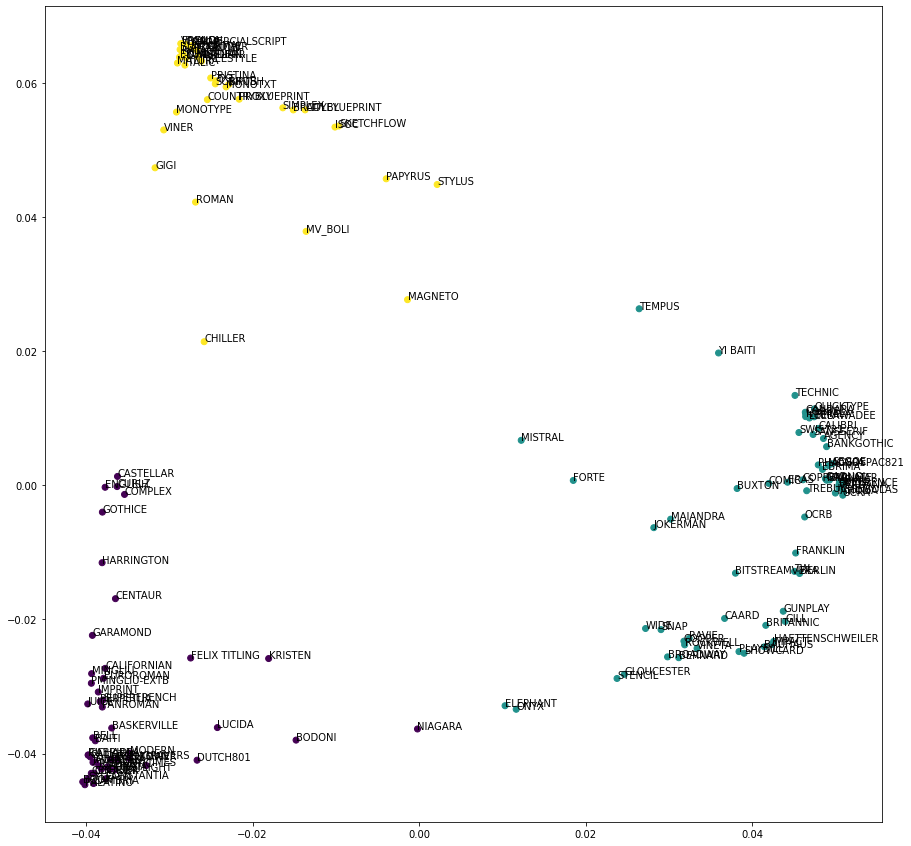

In [10]:
x = eigfont_embeddings_df["embedding_0"]
y = eigfont_embeddings_df["embedding_1"]
fonts = eigfont_embeddings_df["font"]
            
colors=eigfont_embeddings_df["cluster"]
#colors=((eigfont_embeddings_df_cluster_center_i_proximity)*255).astype(int)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.scatter(x, y,c=colors)

for i, txt in enumerate(fonts):
    ax.annotate(txt, (x[i], y[i]))

It seems like that:
* Serifed Fonts = Cluster 0
* San-Serifed Fonts = Cluster 2
* Calligraphic Fonts = Cluster 1

In [11]:
eigfont_embeddings_df.head(11)

,font,embedding_0,embedding_1,cluster,cluster_center_0_distance,cluster_center_1_distance,cluster_center_2_distance
0,SKETCHFLOW,-0.009623,0.053575,2,0.020527,0.027406,0.952067
1,BROADWAY,0.029842,-0.025587,1,0.095355,0.861124,0.043520
2,AGENCY,0.048564,0.006976,1,0.026825,0.942261,0.030913
3,COOPER,0.031805,-0.023243,1,0.069224,0.896379,0.034397
4,REFERENCE,0.050403,0.000015,1,0.016369,0.967358,0.016273
5,PERPETUA,-0.038302,-0.032225,0,0.997889,0.001145,0.000966
6,MODERN,-0.034743,-0.039938,0,0.986761,0.007719,0.005520
7,HIMALAYA,-0.038841,-0.041256,0,0.980625,0.010999,0.008376
8,LUCIDA,-0.024220,-0.036129,0,0.957840,0.026546,0.015613
9,VIVALDI,-0.028619,0.065856,2,0.012480,0.012236,0.975284


We can finally create the training and testing dataset. This will be similar to the very first csv-reading iteration for loop, except that:
* We will include all characters; for this case, those are lowercase and number characters
* The cluster groupings are now the y's
* The x's are individual 20x20 images of the characters

## **Building the Convolutional Neural Network**


In [12]:
x_train = []
x_test = []
y_train = []
y_test = []

font_folder_path = '/kaggle/input/uci-fonts-dataset/'
range_len_passed_font_families = range(len(passed_font_families))
range_len_passed_font_families = tqdm(range_len_passed_font_families)
for i in range_len_passed_font_families:
    passed_font_family = passed_font_families[i]
    #if (((i+1)%25)==0): print(i+1, len(passed_font_families));
    uci_font_family_csv_file_name = passed_font_family + ".csv"
    uci_font_family_csv_file_path = font_folder_path + uci_font_family_csv_file_name
    temp_uci_font_family_df_orig = pd.read_csv(uci_font_family_csv_file_path)
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.sort_values("m_label")#.value_counts()
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["m_label"].isin(m_labels_alphanum_alpha_upper+m_labels_alphanum_alpha_lower+m_labels_alphanum_num)]
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["strength"] <= 0.5]
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["italic"] <= 0.5]
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.drop_duplicates(subset=["m_label","strength","italic"])
    assert temp_uci_font_family_df_orig.shape[0] <= 26+26+50
    temp_uci_font_family_df_pixels = temp_uci_font_family_df_orig[pixel_column_names]

    train_test = np.random.choice([1,0],size=len(temp_uci_font_family_df_pixels), p=[0.75, 0.25])
    train_character_pics_flattened= temp_uci_font_family_df_pixels[train_test.astype(bool)]
    train_character_pics_reshaped = train_character_pics_flattened.values.reshape(train_character_pics_flattened.shape[0],20,20)

    train_ohe = eigfont_embeddings_df[eigfont_embeddings_df["font"]==passed_font_family][cluster_center_i_distance_column_names].values
    train_ohes = np.tile(train_ohe[0],(train_character_pics_flattened.shape[0],1))

    test_character_pics_flattened= temp_uci_font_family_df_pixels[~train_test.astype(bool)]
    test_character_pics_reshaped = test_character_pics_flattened.values.reshape(test_character_pics_flattened.shape[0],20,20)

    test_ohe = eigfont_embeddings_df[eigfont_embeddings_df["font"]==passed_font_family][cluster_center_i_distance_column_names].values
    test_ohes = np.tile(test_ohe[0],(test_character_pics_flattened.shape[0],1))


    x_train += list(train_character_pics_reshaped)
    y_train += list(train_ohes)
    x_test += list(test_character_pics_reshaped)
    y_test += list(test_ohes)

    #unraveled_unsupervised.append(temp_uci_font_family_char_concat)

100%|██████████| 147/147 [00:26<00:00,  5.64it/s]


In [13]:
# For this cell, decide if you want to train with sparse or regular categorical cross entropy
# I went with sparse, which changed the y labels to be scalar (the argmax) rather than softmaxed vectors

IS_SPARSE = True
LOSS_FUNCTION = 'categorical_crossentropy';

if IS_SPARSE:
    LOSS_FUNCTION = 'sparse_categorical_crossentropy'; 
    y_train = np.argmax(np.array(y_train),axis=1)
    y_test = np.argmax(np.array(y_test),axis=1)

In [14]:
N_CLASSES = N_CLUSTERS

In [15]:
def middle_fcn_layer_function(filters, kernel_size, strides, dropout_rate,x):
    x = tf.keras.layers.Conv2D(filters=filters, 
                               kernel_size=kernel_size, 
                               strides=strides,
                               padding="same")(x) 
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

len_classes=N_CLASSES
dropout_rate=0.2

input_layer = tf.keras.layers.Input(shape=(None, None, 1)) # maybe change shape to just None, None if grayscale
## Middle FCN Layer

x = middle_fcn_layer_function(filters=5, kernel_size=3, strides=1, dropout_rate=dropout_rate, x=input_layer)
x = middle_fcn_layer_function(filters=10, kernel_size=3, strides=1, dropout_rate=dropout_rate, x=x)
## take account of kernel size= 3 isfilter size not != RGB
## should it be bigger?

x = middle_fcn_layer_function(filters=20, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)
#x = middle_fcn_layer_function(filters=256, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)
#x = middle_fcn_layer_function(filters=512, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)

x = middle_fcn_layer_function(filters=10, kernel_size=1, strides=1, dropout_rate=dropout_rate, x=x)
## penult layer

## Last FCN Layer
x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
predictions = tf.keras.layers.Activation('softmax')(x)
model = tf.keras.Model(inputs=input_layer, outputs=predictions)
## This is functional API
## https://keras.io/guides/functional_api/
model.compile(optimizer=tf.optimizers.Adam(),loss=LOSS_FUNCTION,metrics=['accuracy'])

2022-05-15 22:41:54.724579: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 5)     50        
_________________________________________________________________
dropout (Dropout)            (None, None, None, 5)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 5)     20        
_________________________________________________________________
activation (Activation)      (None, None, None, 5)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 10)    460       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 10)    0     

In [17]:
model.fit(np.array(x_train), (y_train), epochs = 10)

2022-05-15 22:41:55.502675: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
215/215 [==============================] - 5s 17ms/step - loss: 1.0249 - accuracy: 0.4946
Epoch 2/10
215/215 [==============================] - 4s 17ms/step - loss: 0.9233 - accuracy: 0.5539
Epoch 3/10
215/215 [==============================] - 4s 17ms/step - loss: 0.8604 - accuracy: 0.6151
Epoch 4/10
215/215 [==============================] - 3s 16ms/step - loss: 0.8255 - accuracy: 0.6345
Epoch 5/10
215/215 [==============================] - 3s 16ms/step - loss: 0.8085 - accuracy: 0.6569
Epoch 6/10
215/215 [==============================] - 4s 17ms/step - loss: 0.7993 - accuracy: 0.6560
Epoch 7/10
215/215 [==============================] - 4s 17ms/step - loss: 0.7779 - accuracy: 0.6701
Epoch 8/10
215/215 [==============================] - 4s 17ms/step - loss: 0.7649 - accuracy: 0.6819
Epoch 9/10
215/215 [==============================] - 4s 17ms/step - loss: 0.7642 - accuracy: 0.6813
Epoch 10/10
215/215 [==============================] - 4s 17ms/step - loss: 0.7582 - accura

In [18]:
((np.argmax(model.predict(np.array(x_test)),axis=1))==y_test).mean()

0.7078299776286353

In [19]:
PATH_FOLDER = ""
MODEL_FILE_PATH = PATH_FOLDER + "/versatile_font_kn_embedding_cluster_classifier_cnn1.h5"
model.save(MODEL_FILE_PATH)

# START FROM HERE

# ORIG MODEL IS PATH_FOLDER + "/versatile_font_embedding_cluster_classifier_cnn.h5"
# KNEIGHBOR MODEL IS PATH_FOLDER + "/versatile_font_kn_embedding_cluster_classifier_cnn.h5"

model1 = keras.models.load_model(MODEL_FILE_PATH)

## **OpenCV for Character Segmentation, and Font Type Classification of Photo-Scanned Text**

* We can now finally input a picture of text through the CNN and find which "font type" (serif, san-serif, decorated) it is mostly classified with.
* I originally intended for this project to be used on historic, archived, photo-scanned documents. This means things like Newspapers, postcards, war letters, etc. 
* Obviously, please use sources from the Roman alphabet
* I will be using an old Western Union telegram as my example

In [20]:
#url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwallup.net%2Fwp-content%2Fuploads%2F2016%2F03%2F10%2F343179-landscape-nature.jpg"
#url = "https://mha.mun.ca/mha/cw/images/margins/scanned_letters/second-letter001.jpg"
#url = "https://upload.wikimedia.org/wikipedia/commons/f/f5/Spencerian_example.jpg"
#url = "https://www2.wheaton.edu/bgc/archives/images/CNs/285/285-027-014/005.jpg"
url = "https://media.defense.gov/2016/Jan/21/2001336426/-1/-1/0/160121-F-HF287-001.JPG"
url_response = urllib.request.urlopen(url)
img = cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8),-1)
img = img[:,:,::-1]

758


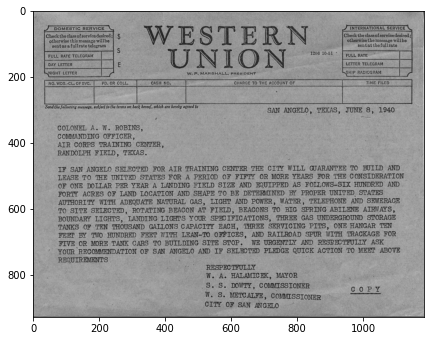

In [21]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = gray
plt.imshow(img, cmap='gray')
img = 255-img

cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
#ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

#th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
find_contours_output = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
#print((find_contours_output[0]))

contours = find_contours_output[0]
hier =  find_contours_output[1]
print(len(contours))

* The cv2 package will perform image segmentation to cut out each character it can find on the image. But it's not very perfect, as it might clump many letters together, or pick up things that aren't text

Predicted Classes are  [0.75950134 0.1891042  0.05139446]


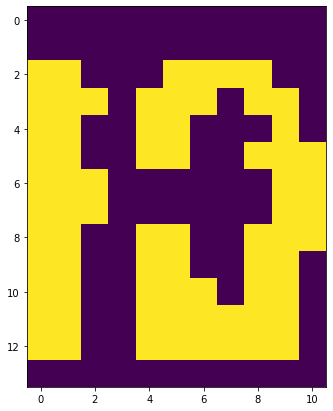

In [22]:
# one exampleof an extracted image
contour_i = 400
x, y, w, h = cv2.boundingRect(contours[contour_i])
cnt = contours[contour_i]
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)

max_x = np.max(box[:,0])
min_x = np.min(box[:,0])
max_y = np.max(box[:,1])
min_y = np.min(box[:,1])

extraction = img[min_y:max_y,min_x:max_x]
plt.imshow(255-img[min_y:max_y,min_x:max_x])
prediction_vector = model1.predict(np.array([extraction]))[0]
print("Predicted Classes are ",prediction_vector)

In [23]:
predictions = []
range_len_contours = range(len(contours))
range_len_contours = tqdm(range_len_contours)
for contour_i in range_len_contours:
    #if (((contour_i+1)%100)==0): print(contour_i+1, (len(contours)));
    try:
        x, y, w, h = cv2.boundingRect(contours[contour_i])
        cnt = contours[contour_i]
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        max_x = np.max(box[:,0])
        min_x = np.min(box[:,0])
        max_y = np.max(box[:,1])
        min_y = np.min(box[:,1])

        extraction = img[min_y:max_y,min_x:max_x]
        prediction = model1.predict(np.array([extraction]))[0]
        predictions.append(prediction)
    except:
        pass
segmented_character_font_embedding_cluster_classification_predictions = predictions

100%|██████████| 758/758 [00:44<00:00, 17.16it/s]


In [24]:
segmented_character_font_embedding_cluster_classification_predictions_summed = np.nan_to_num(np.array(segmented_character_font_embedding_cluster_classification_predictions)).sum(axis=0)# = predictions

In [25]:
segmented_character_font_embedding_cluster_classification_predictions_summed

array([444.08487, 166.29118, 107.62366], dtype=float32)

* After totalling up to the predictions for all the extracted subsets found by cv2, the serifed category (first index) seems to be the predominant font category of the input photoscanned telegram.